# Agents Workshop

Note: see [these slides](https://docs.google.com/presentation/d/1Iqn7rLTnBZuSoQ34NMLDyD1ROwA7A3_1mBonAWgQWo0/edit?usp=sharing) as an introduction to the workshop.

This workshop reviews common patterns for agentic systems. 

In describing these systems, it can be useful to make a distinction between "workflows" and "agents". 

One way to think about this difference is nicely explained [here](https://www.anthropic.com/research/building-effective-agents):

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a diagram of different workflow and agent patterns:

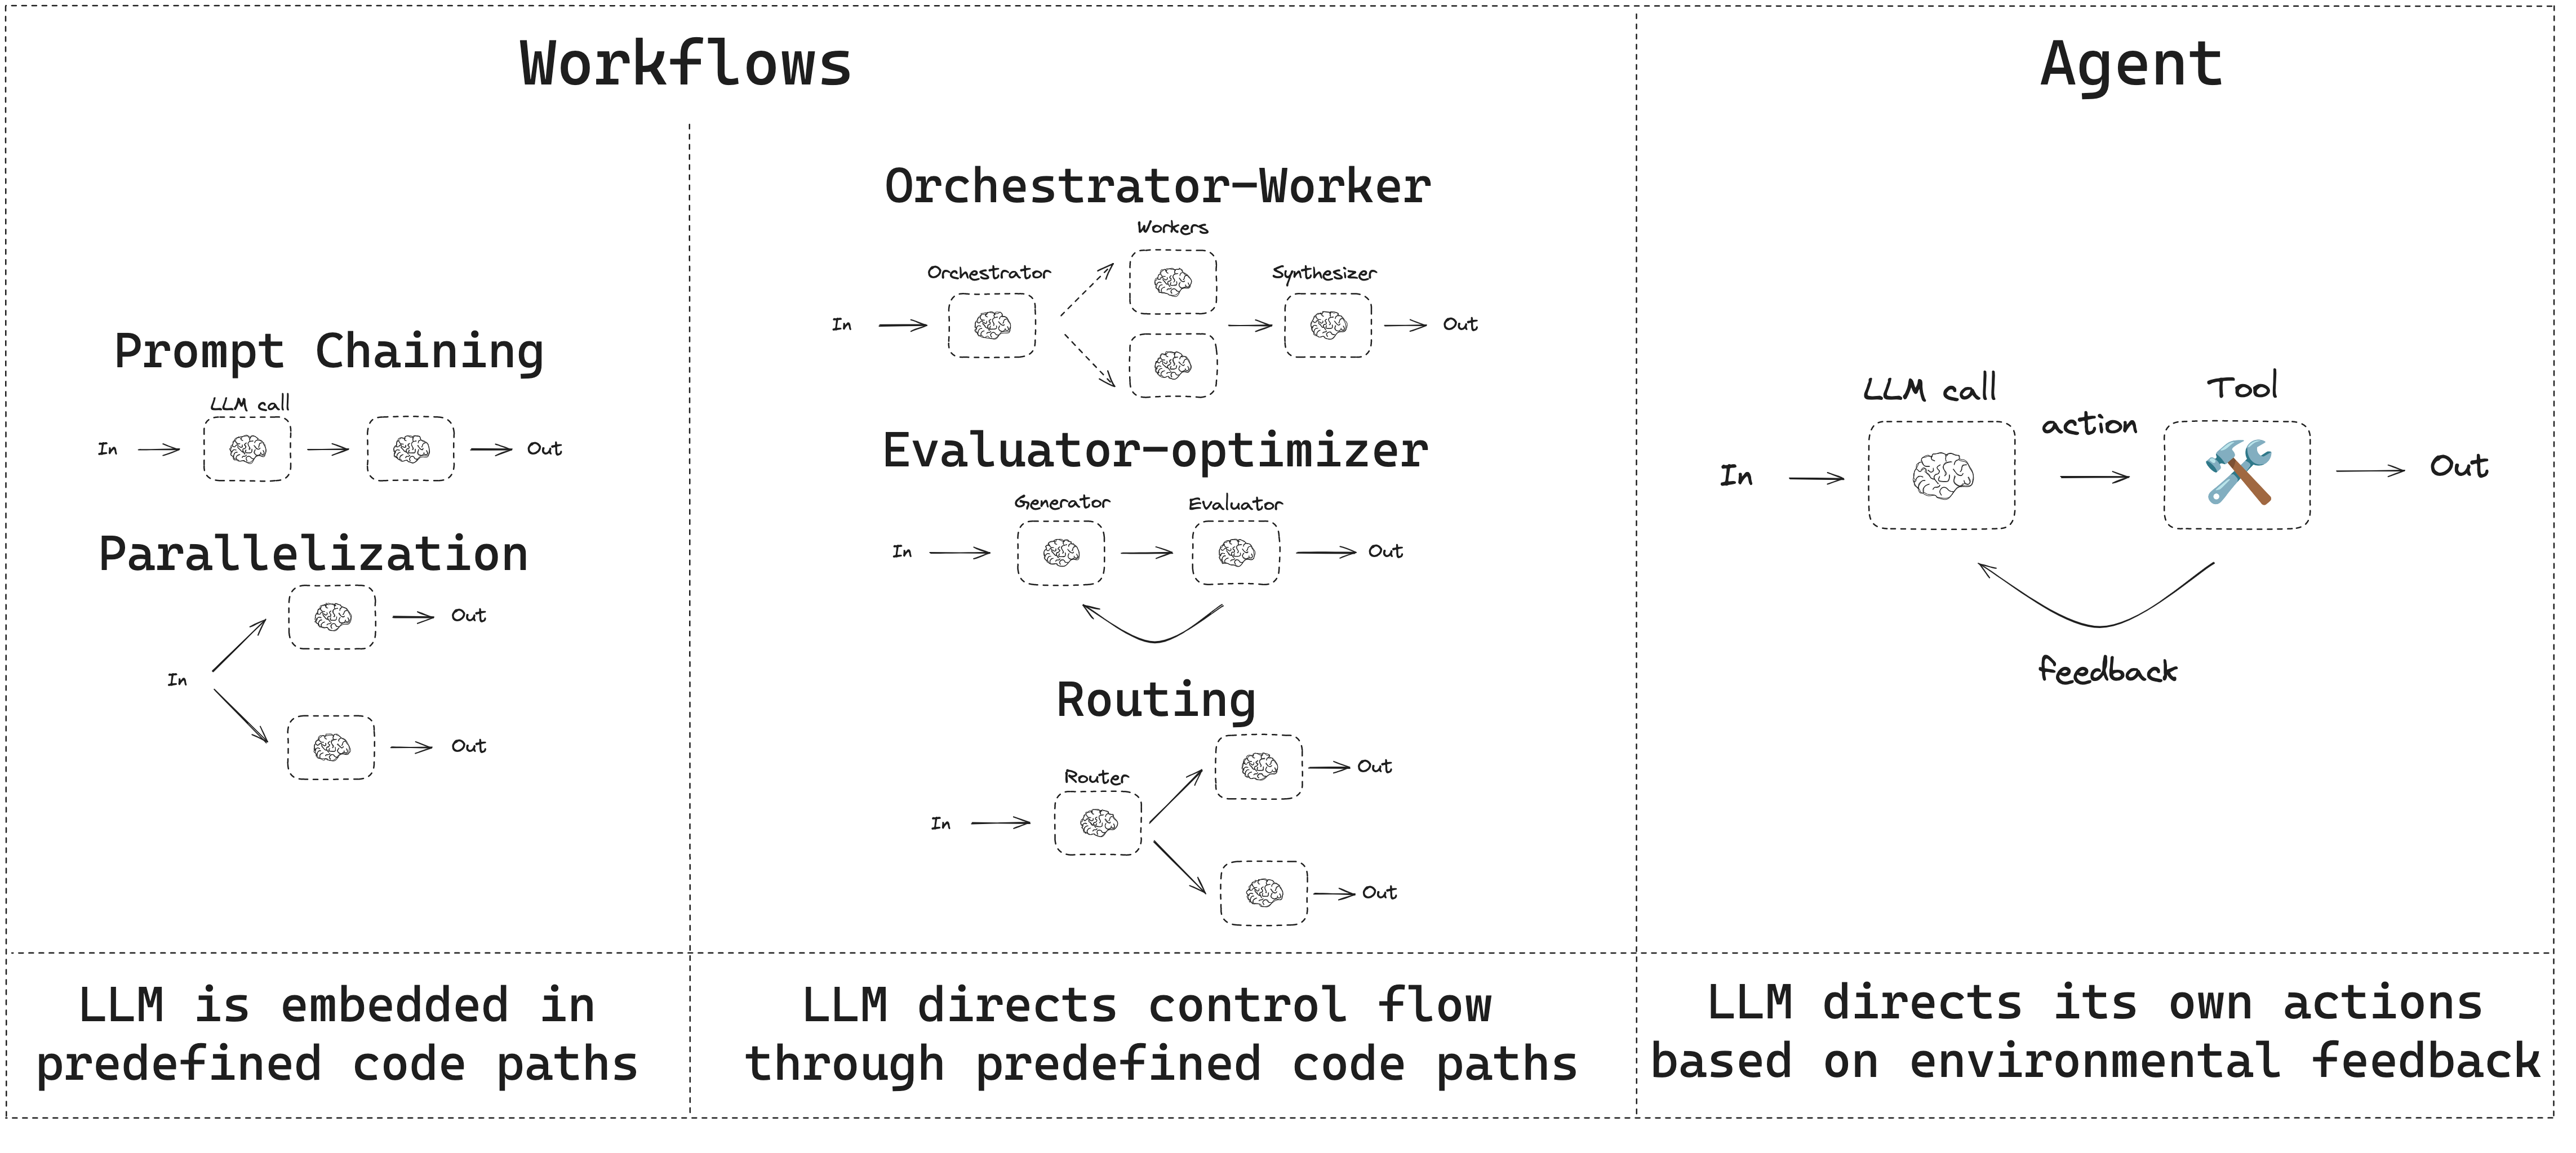

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/). 

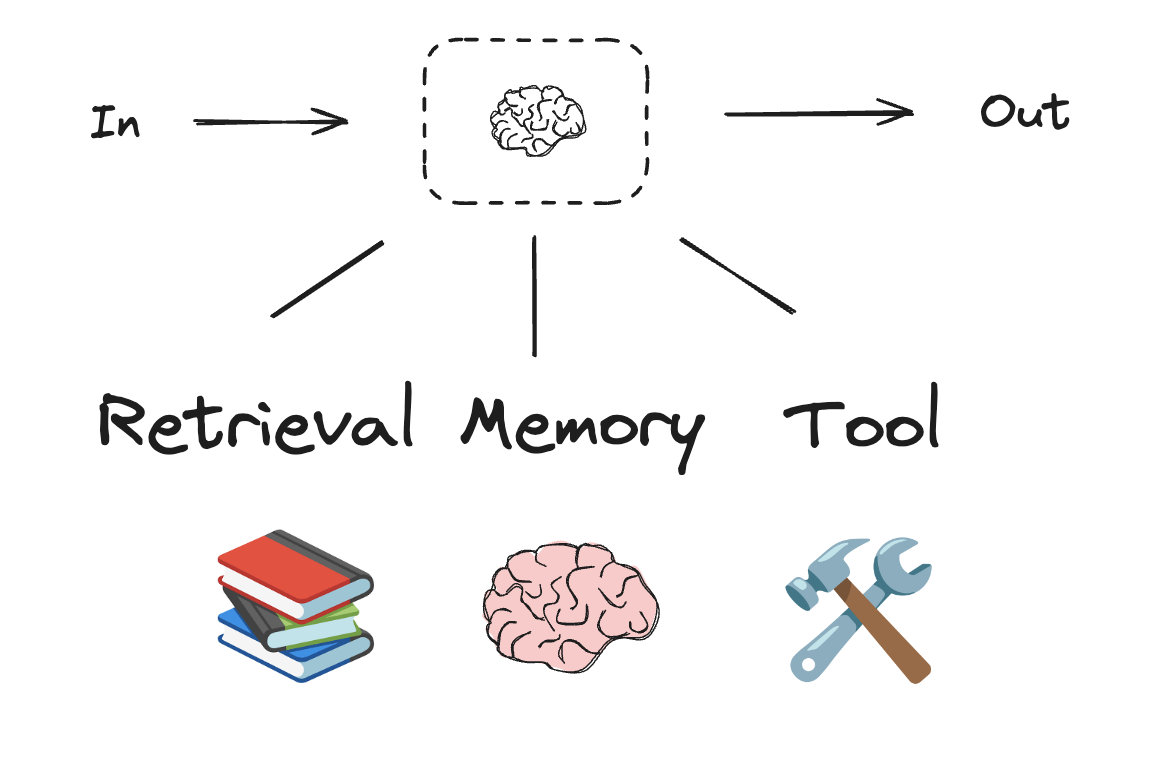

In [ ]:
! pip install langchain_core langchain_anthropic langgraph 

In [5]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

We'll also use [LangSmith](https://docs.smith.langchain.com/observability) for tracing.

In [6]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

### Initialize the LLM 

In [1]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

Large Language Models (LLMs) are advanced machine learning models that excel in a wide range of language-related tasks such as text generation, translation, summarization, question answering, and more, without needing task-specific fine tuning for every scenario. 

Modern LLMs are typically accessed through a [chat model](https://python.langchain.com/docs/concepts/chat_models/#standard-parameters) interface that takes a list of messages as input and returns a message as output.

LangChain chat models implement the [BaseChatModel interface](https://python.langchain.com/docs/concepts/chat_models/#interface), which supports a few [useful methods](https://python.langchain.com/docs/concepts/chat_models/#key-methods): 

* `invoke`: The primary method for interacting with a chat model. It takes a list of messages as input and returns a list of messages as output.
* `stream`: A method that allows you to stream the output of a chat model as it is generated.
* `batch`: A method that allows you to batch multiple requests to a chat model together for more efficient processing.
* `bind_tools`: A method that allows you to bind a tool to a chat model for use in the model's execution context.
* `with_structured_output`: A wrapper around the invoke method for models that natively support structured output.

LangChain has integrations [with many chat model providers](https://python.langchain.com/docs/integrations/chat/).

### Invoking the LLM 

In [2]:
# Invoke the model with messages 
messages = [{"role": "user", "content": "What is the capital of France?"}]
response = llm.invoke(messages)
print(response.content)

The capital of France is Paris.


### Using Structured Output 

We can define a schema for the output of the LLM and [use the `with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/) method to augment the LLM with this schema.

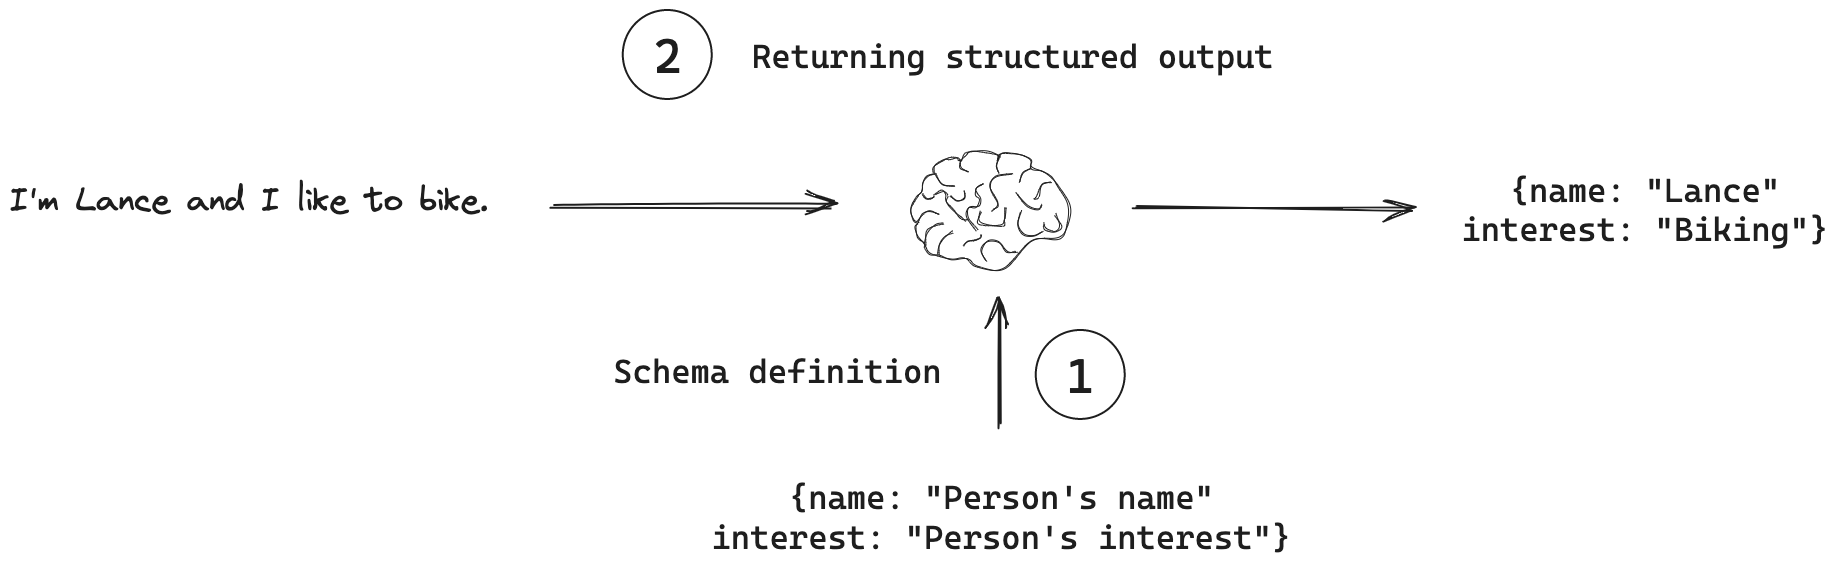

In [9]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

print(output.search_query)
print(output.justification)

relationship between calcium CT score and high cholesterol atherosclerosis
This search query will help find information about how coronary calcium scoring relates to cholesterol levels and cardiovascular risk, as calcium scoring is used to detect calcified plaque buildup which can be related to high cholesterol.


### Tool Calling 

We can define a tool [and use the `bind_tools` method](https://python.langchain.com/docs/concepts/tool_calling/) to augment the LLM with this tool.

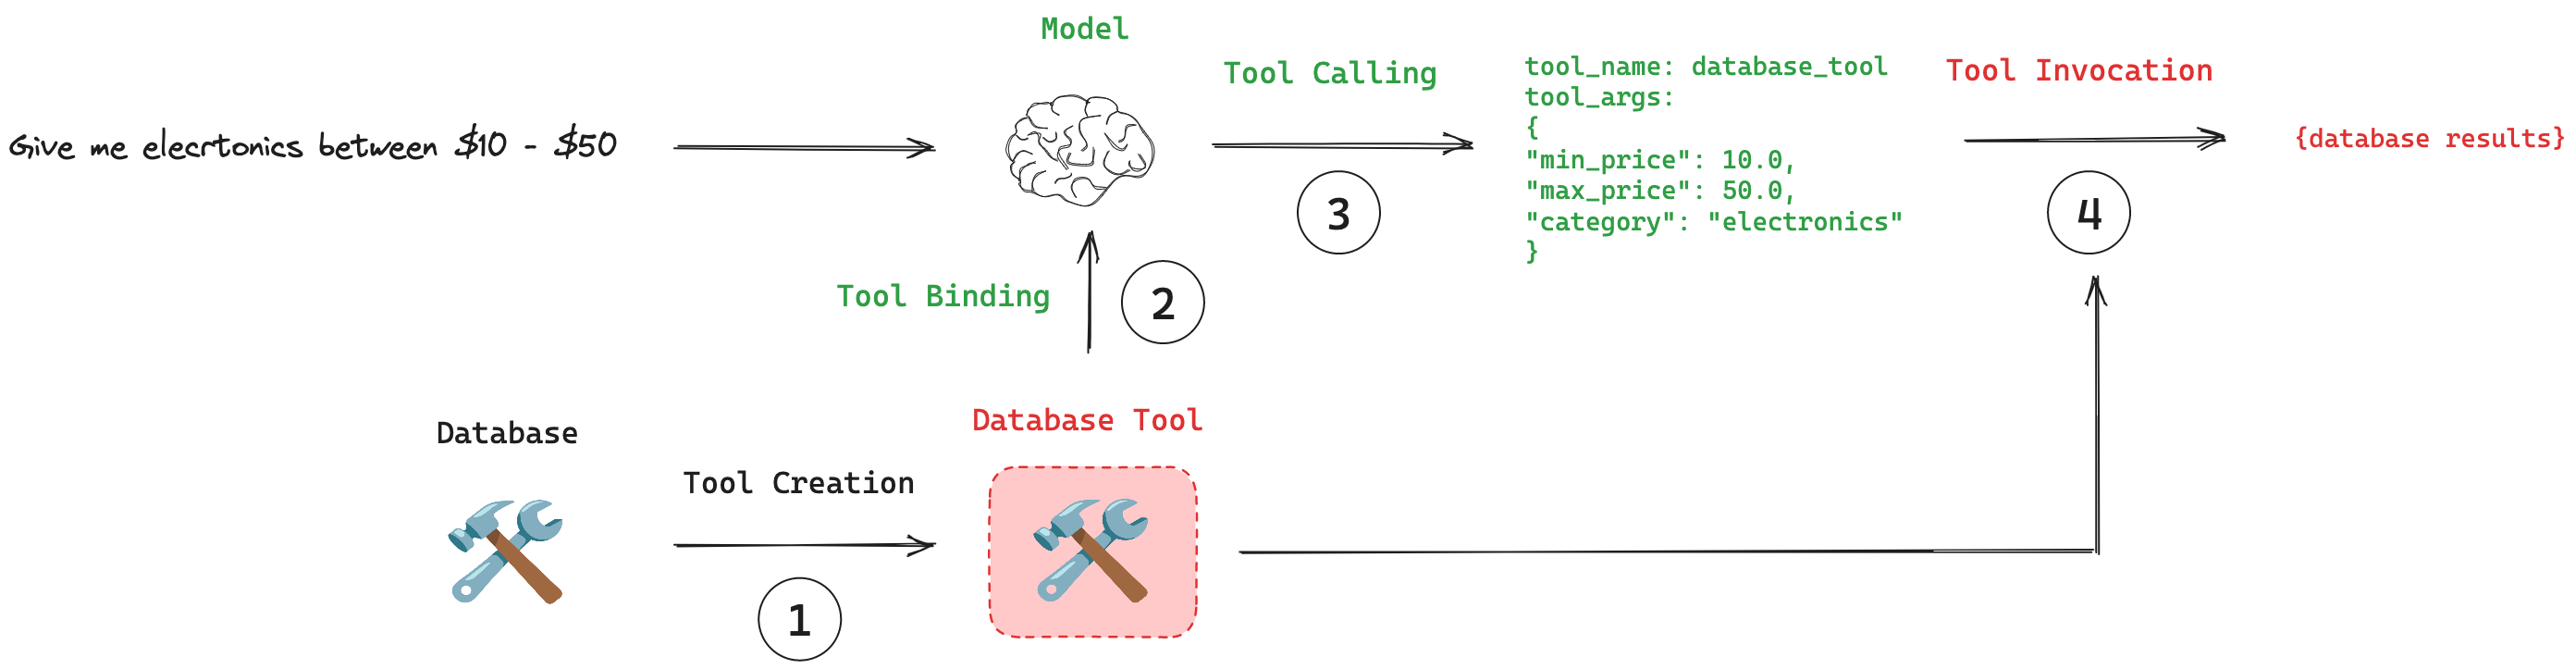

In [5]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'toolu_01TVMByUKPheJPRyBJGHeLY3',
  'type': 'tool_call'}]

# LangGraph

LangGraph [provides low-level supporting infrastructure](https://langchain-ai.github.io/langgraph/concepts/high_level/) that *sits underneath any workflow or agent*. 

It does not abstract prompts or architecture, and provides three central benefits:

* **LangGraph has a persistence layer**, which offers a number of benefits. `Memory`: LangGraph persists arbitrary aspects of your application's state, supporting memory of conversations and other updates within and across user interactions. `Human-in-the-loop`: Because state is checkpointed, execution can be interrupted and resumed, allowing for decisions, validation, and corrections via human input.

* **Streaming**: LangGraph also provides support for streaming workflow / agent state to the user (or developer) over the course of execution. LangGraph supports streaming of both events (such as feedback from a tool call) and tokens from LLM calls embedded in an application.

* **Debugging and Deployment**: LangGraph provides an easy onramp for testing, debugging, and deploying applications via LangGraph Platform. This includes Studio, an IDE that enables visualization, interaction, and debugging of workflows or agents. This also includes numerous options for deployment.

## Workflows

### Prompt chaining

In prompt chaining, each LLM call processes the output of the previous.

There can be optional programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track. 

It is ideal for situations where the task can be decomposed into fixed subtasks and may trade off latency for higher accuracy by making each LLM call an easier task.

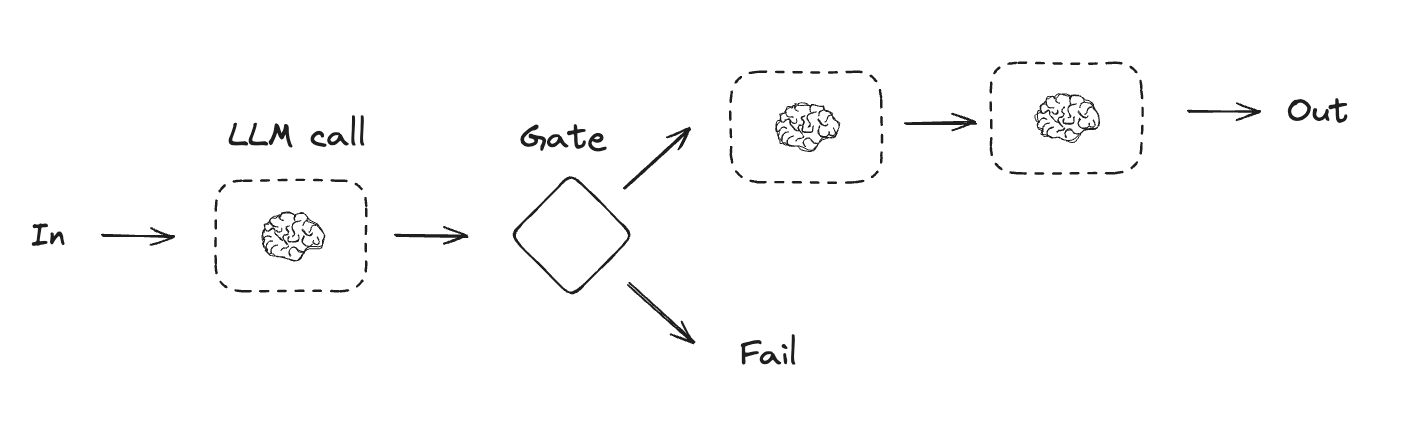

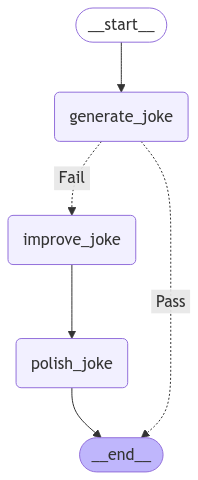

Initial joke:
Here's a cat joke:

What do you call a cat that likes to bowl?
An alley cat!

--- --- ---

Improved joke:
Here's the joke with added wordplay:

What do you call a cat that likes to bowl?
An alley cat! They're really good at getting strikes... purr-fect form, if you ask me! And they never go in the gutter because they're feline fine!

(The wordplay includes "purr-fect" as a play on "perfect" and "feline fine" as a play on "feeling fine," while also incorporating bowling terms like "strikes" and "gutter")

--- --- ---

Final joke:
Here's the joke with a surprising twist:

What do you call a cat that likes to bowl?
An alley cat! They're really good at getting strikes... purr-fect form, if you ask me! And they never go in the gutter because they're feline fine! But here's the weird thing - they always insist on using a mouse ball instead of a bowling ball!

(The twist introduces the unexpected "mouse ball" element, playing on both a cat's natural prey and bowling equipment wh

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")


### Routing

Routing classifies an input and directs it to a followup task, allowing for separation of concerns. 

Routing works well for complex tasks where there are distinct categories that are better handled separately and where classification can be handled accurately.

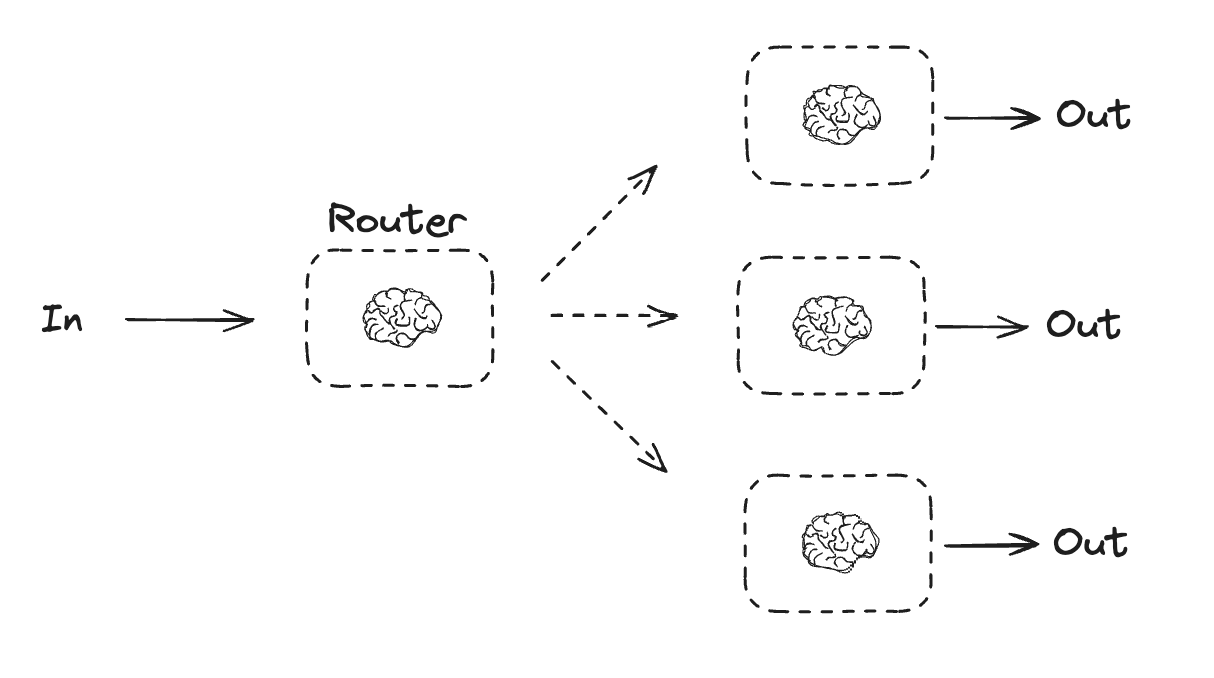

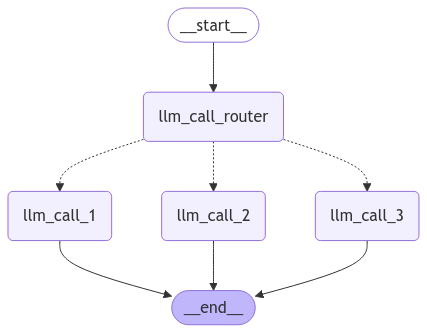

Here's a cat joke for you:

Why don't cats like online shopping?

They prefer a cat-alog!


In [7]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])


## Agents

Agents are typically implemented as an LLM performing actions (via tool-calling) based on environmental feedback in a loop.

Agents can be used for open-ended problems where it’s difficult or impossible to predict the control flow (workflow, above).

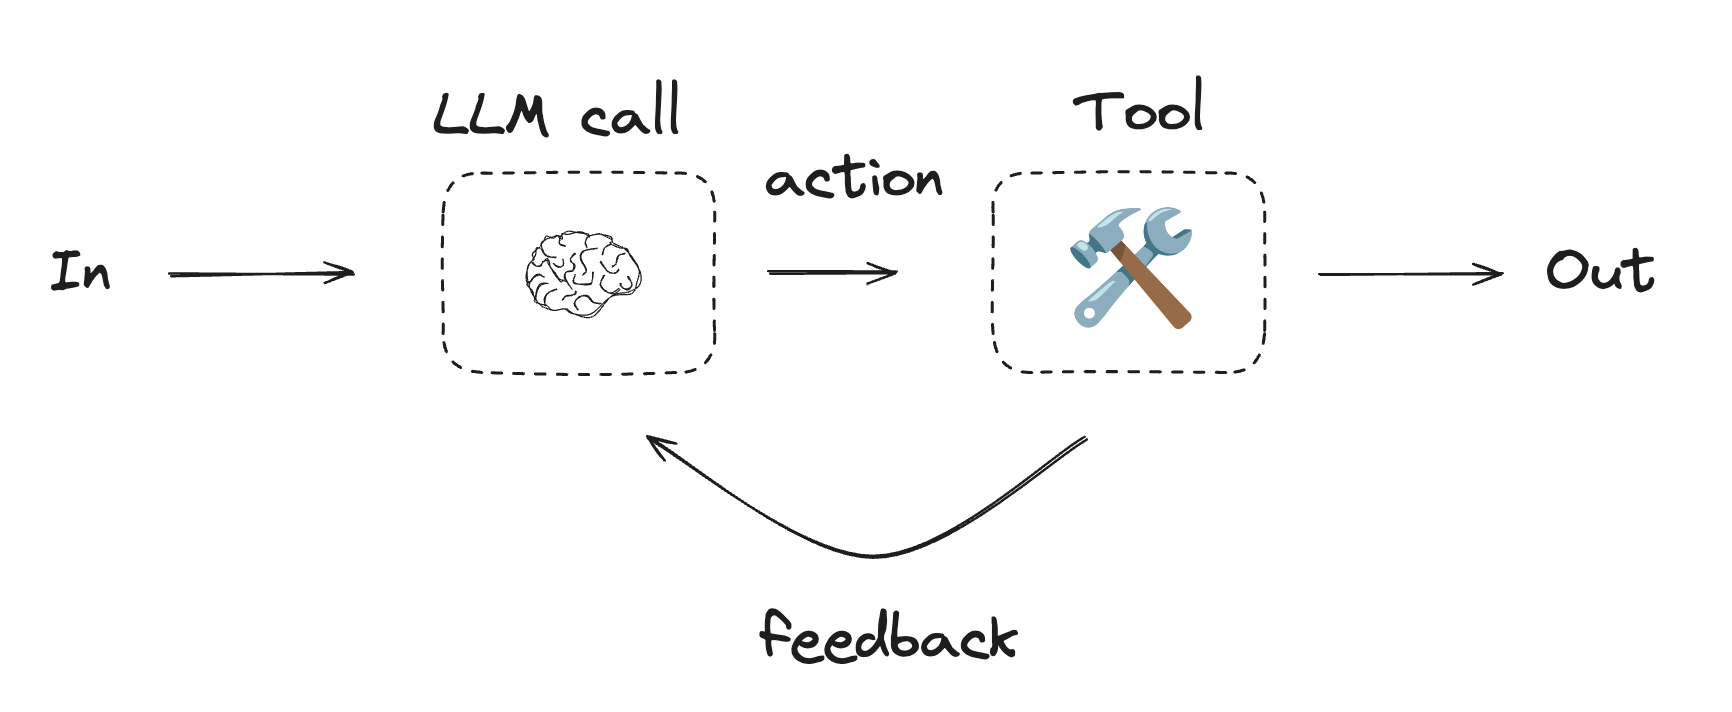

In [1]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

NameError: name 'llm' is not defined

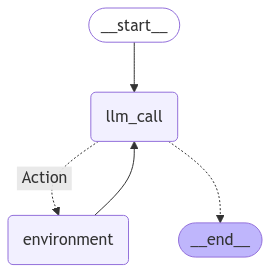

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

[{'text': "I'll help you add 3 and 4 using the `add` function.", 'type': 'text'}, {'id': 'toolu_01WJQ5BwtrfUjj4KZHKB4XWY', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01WJQ5BwtrfUjj4KZHKB4XWY)
 Call ID: toolu_01WJQ5BwtrfUjj4KZHKB4XWY
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

### Pre-built

LangGraph also provides a pre-built method for creating an agent as defined above (using the create_react_agent function):

https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

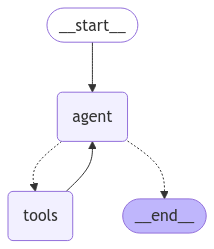

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

[{'text': "I'll help you add 3 and 4 using the `add` function.", 'type': 'text'}, {'id': 'toolu_01X1xWbzPmb3yKe9JJbh6bz9', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01X1xWbzPmb3yKe9JJbh6bz9)
 Call ID: toolu_01X1xWbzPmb3yKe9JJbh6bz9
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [15]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()
